In [2]:
#importing libraries
import pandas as pd
import yfinance as yf
import numpy as np 

In [3]:
#Pulling the data
eth_data = yf.download('ETH-USD', start='2017-01-01', end='2022-01-01')
eth_df = pd.DataFrame(eth_data)

[*********************100%***********************]  1 of 1 completed


In [4]:
eth_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984


In [5]:
eth_df['actual_returns'] = eth_df['Close'].pct_change()
eth_df.dropna()
display(eth_df.head())
display(eth_df.tail())

,Open,High,Low,Close,Adj Close,Volume,actual_returns
Date,,,,,,,
2017-11-09,308.644989,329.451996,307.056000,320.884003,320.884003,893249984,NaN
2017-11-10,320.670990,324.717987,294.541992,299.252991,299.252991,885985984,-0.067411
2017-11-11,298.585999,319.453003,298.191986,314.681000,314.681000,842300992,0.051555
2017-11-12,314.690002,319.153015,298.513000,307.907990,307.907990,1613479936,-0.021523
2017-11-13,307.024994,328.415009,307.024994,316.716003,316.716003,1041889984,0.028606


,Open,High,Low,Close,Adj Close,Volume,actual_returns
Date,,,,,,,
2021-12-28,4037.538086,4037.538086,3769.280029,3800.893066,3800.893066,17299472803,-0.058613
2021-12-29,3797.436279,3827.981934,3612.795898,3628.531738,3628.531738,15722555672,-0.045348
2021-12-30,3632.219727,3767.559814,3595.204834,3713.852051,3713.852051,12925377999,0.023514
2021-12-31,3713.430176,3807.288818,3636.869873,3682.632812,3682.632812,14157285268,-0.008406
2022-01-01,3683.047119,3769.917969,3682.286621,3769.697021,3769.697021,9776191466,0.023642


In [6]:
short_window = 8
eth_df['sma_fast'] = eth_df['Close'].rolling(window=short_window).mean().dropna()


In [7]:
long_window = 21
eth_df['sma_slow'] = eth_df['Close'].rolling(window=long_window).mean().dropna()


In [8]:
eth_df = eth_df.dropna()
eth_df.head()

,Open,High,Low,Close,Adj Close,Volume,actual_returns,sma_fast,sma_slow
Date,,,,,,,,,
2017-11-29,473.281006,522.307007,425.071014,427.523010,427.523010,2675940096,-0.095959,448.014378,376.523430
2017-11-30,431.214996,465.497009,401.243011,447.114014,447.114014,1903040000,0.045824,456.322128,382.534383
2017-12-01,445.209015,472.609009,428.312012,466.540009,466.540009,1247879936,0.043448,463.368881,390.500432
2017-12-02,466.851013,476.239014,456.653015,463.449005,463.449005,943649984,-0.006625,461.936131,397.584622
2017-12-03,463.704987,482.813995,451.851990,465.852997,465.852997,990556992,0.005187,461.883255,405.105813


In [9]:
X = eth_df[['sma_fast','sma_slow']].copy().dropna()
display(X.head())
display(X.tail())

,sma_fast,sma_slow
Date,,
2017-11-29,448.014378,376.523430
2017-11-30,456.322128,382.534383
2017-12-01,463.368881,390.500432
2017-12-02,461.936131,397.584622
2017-12-03,461.883255,405.105813


,sma_fast,sma_slow
Date,,
2021-12-28,4019.675995,4002.442511
2021-12-29,3970.709961,3963.831741
2021-12-30,3937.179016,3944.500128
2021-12-31,3884.006165,3933.744734
2022-01-01,3849.220428,3918.756383


In [10]:
# target set 
eth_df['signal'] = 0.0

In [11]:
# buy signal
eth_df.loc[(eth_df['actual_returns'] >= 0), 'signal'] = 1


In [12]:
# sell signal
eth_df.loc[(eth_df['actual_returns'] < 0), 'signal'] = -1

In [14]:
y = eth_df['signal'].copy()

In [15]:
from pandas.tseries.offsets import DateOffset

In [16]:
train_start = X.index.min()
print(train_start)

2017-11-29 00:00:00


In [17]:
train_end = X.index.min() + DateOffset(years=3)
print(train_end)

2020-11-29 00:00:00


In [18]:
X_train = X.loc[train_start:train_end]
y_train = y.loc[train_start:train_end]
X_train.head()

,sma_fast,sma_slow
Date,,
2017-11-29,448.014378,376.523430
2017-11-30,456.322128,382.534383
2017-12-01,463.368881,390.500432
2017-12-02,461.936131,397.584622
2017-12-03,461.883255,405.105813


In [19]:
X_test = X.loc[train_end:]
y_test = y.loc[train_end:]
X_test.head()

,sma_fast,sma_slow
Date,,
2020-11-29,561.423660,506.770440
2020-11-30,568.520462,514.898034
2020-12-01,565.879227,521.452535
2020-12-02,565.186050,527.899764
2020-12-03,570.938812,535.314215


In [20]:
from sklearn.preprocessing import StandardScaler

In [21]:
scaler = StandardScaler()
X_scaler = scaler.fit(X_train)
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [22]:
from sklearn import svm
from sklearn.metrics import classification_report

In [23]:
svm_model = svm.SVC()
svm_model = svm_model.fit(X_train_scaled, y_train)
training_signal_predictions = svm_model.predict(X_train_scaled)
training_signal_predictions[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [24]:
training_report = classification_report(y_train, training_signal_predictions)
print(training_report)

              precision    recall  f1-score   support

        -1.0       0.61      0.10      0.17       540
         1.0       0.52      0.94      0.67       557

    accuracy                           0.53      1097
   macro avg       0.56      0.52      0.42      1097
weighted avg       0.56      0.53      0.42      1097



In [25]:
testing_signal_predictions = svm_model.predict(X_test_scaled)

In [26]:
svm_testing_report = classification_report(y_test, testing_signal_predictions)
print(svm_testing_report)

              precision    recall  f1-score   support

        -1.0       0.40      0.11      0.17       178
         1.0       0.55      0.87      0.67       221

    accuracy                           0.53       399
   macro avg       0.47      0.49      0.42       399
weighted avg       0.48      0.53      0.45       399



In [28]:
predictions_df = pd.DataFrame(index=X_test.index)
predictions_df['predicted_signal'] = testing_signal_predictions
predictions_df['actual_returns'] = eth_df['actual_returns']
predictions_df['trading_algo_returns'] = predictions_df['actual_returns'] * predictions_df['predicted_signal']
predictions_df.head()

,predicted_signal,actual_returns,trading_algo_returns
Date,,,
2020-11-29,1.0,0.069725,0.069725
2020-11-30,1.0,0.067884,0.067884
2020-12-01,1.0,-0.044757,-0.044757
2020-12-02,1.0,0.018777,0.018777
2020-12-03,1.0,0.030678,0.030678


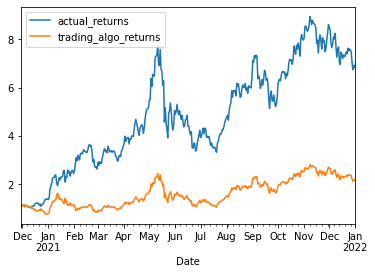

In [29]:
(1 + predictions_df[['actual_returns', 'trading_algo_returns']]).cumprod().plot()

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
log_reg_model = LogisticRegression()
log_reg_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [32]:
logreg_train_signal_pred = log_reg_model.predict(X_train_scaled)
logreg_train_signal_pred[:10]


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
logreg_train_report = classification_report(y_train, logreg_train_signal_pred)
print(logreg_train_report)

              precision    recall  f1-score   support

        -1.0       0.51      0.21      0.30       540
         1.0       0.51      0.80      0.63       557

    accuracy                           0.51      1097
   macro avg       0.51      0.51      0.46      1097
weighted avg       0.51      0.51      0.47      1097



In [34]:
logreg_test_signal_pred = log_reg_model.predict(X_test_scaled)


In [35]:
logreg_test_report = classification_report(y_test, logreg_test_signal_pred)


In [36]:
print('Logistic Regression Classification Report')
print(logreg_test_report)

Logistic Regression Classification Report
              precision    recall  f1-score   support

        -1.0       0.46      0.78      0.58       178
         1.0       0.61      0.28      0.38       221

    accuracy                           0.50       399
   macro avg       0.54      0.53      0.48       399
weighted avg       0.55      0.50      0.47       399



In [37]:
print('SVM Classification Report')
print(svm_testing_report)

SVM Classification Report
              precision    recall  f1-score   support

        -1.0       0.40      0.11      0.17       178
         1.0       0.55      0.87      0.67       221

    accuracy                           0.53       399
   macro avg       0.47      0.49      0.42       399
weighted avg       0.48      0.53      0.45       399



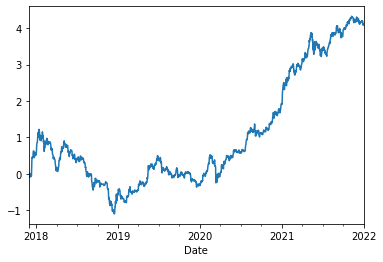

In [38]:
eth_df['actual_returns'].cumsum().plot()